In [2]:
using Revise
using SeisMain, SeisPlot, SeisProcessing
using FFTW, LinearAlgebra, PyPlot

# Developing packages
using IterativeMethods
using HCDSP
using snr

In [3]:
# Source position
sx = 540; sy = 204;

# Receivers and offset
nx = 50;  ny = 5;
rx = zeros(nx*ny,1);
ry = zeros(nx*ny,1);
 h = zeros(nx*ny,1);

k = 0;
for il in 1:ny, xl in 1:nx
     k = k+1;
     ry[k,1] = (il-1)*150 + randn()*5.0;
     rx[k,1] = (xl-1)*25  + randn()*5.0;
      h[k,1] = sqrt( (rx[k,1]-sx)^2 + (ry[k,1]-sy)^2 );
end   

nh = length(h)

250

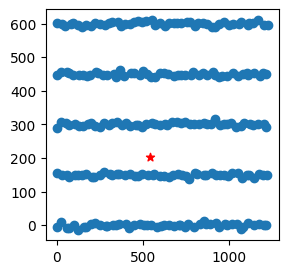

PyObject <matplotlib.collections.PathCollection object at 0x7f464ee26048>

In [4]:
fig = figure("Source-receiver",figsize=(3,3))

scatter(rx,ry)
scatter(sx,sy,color="red",marker="*")

In [4]:
function irregular_hyperbolic_events(dt,nt,h,tau,vel,amp,f0,fmin,fmax)
    
    # Padding and allocation
    nfft = (2 * nextpow(2, nt));
    
    # Offsets and events
    nh = length(h)
    ns = length(vel)
    
    # Allocation
    OUT  = zeros(nt,nh)
    OUTF = complex.(zeros(nfft,nh))
    
    # Wavelet
     nw = length(wav);
    append!(wav,zeros(nfft-nw))
    fft!(wav,1)
    
    # Freq range
    ω_range = freq_indexes(fmin,fmax,dt,nfft)
    
    # Imaginary unit
    im = complex(0,1)
    
    # Loop over (positive) freqs
    @inbounds for iω in ω_range
        # Freq
        f = (iω-1)/nfft/dt;
        ω = 2*pi*f;
        
        Ac = complex.(zeros(nh,ns))
        for i in 1:nh, j in 1:ns
             t = sqrt(tau[j]^2 + (h[i] / vel[j])^2); 
             Ac[i,j] = exp(-im*ω*t);
        end                                   
        
        # Coefficients
        m = wav[iω] .* amp;
        
        # Output
        OUTF[iω,:] .= Ac*m;
    end
    
    # Symmetries
    conj_symmetry!(OUTF);
    
    # ifft and truncation
    OUT = real( ifft!(OUTF,1) )[1:nt,:];

    # Return
    return OUT 
end

irregular_hyperbolic_events (generic function with 1 method)

In [5]:
# Parameters for P-wave hyperbolas
dt = 2/1000;
nt = 1001;
f0 = 20; fmin,fmax=0,100;
tau = [0.3, 0.39,  0.5, 0.6,  0.83,  1.2];       # intercept of hyperbolas P wave    
amp = [1.0, 0.8,  -1.0, 1.1, -0.9,   0.6];       # amplitude of hyperbolas (signal)
vel = [2.0, 2.4,   3.0, 3.4,  3.4,   4.0]*1000;  # rms velocity of hyperbolas (signal)   
apex = zero(vel);

In [6]:
uz = irregular_hyperbolic_events(dt,nt,h,tau,vel,amp,f0,fmin,fmax);
SeisPlotTX(uz,wbox=3,hbox=3,oy=0,dy=dt)

UndefVarError: UndefVarError: irregular_hyperbolic_events not defined

In [7]:
# Parameters for ground-roll
fG = 12;
fD = [10.0,20.0];   
vmin = [400.0,600.0];
vmax = [900.0,900.0];
ampx = (1 + rand()) .* [1,-1];
ampz = (1 + rand()) .* [1,-1];

gz = linear_dispersive_events(dt,nt,h,vmin,vmax,ampx,fD,fmin,fmax,fG);
gx = linear_dispersive_events(dt,nt,h,vmin,vmax,ampz,fD,fmin,fmax,fG);     

In [8]:
# Observation
d = uz + gz;

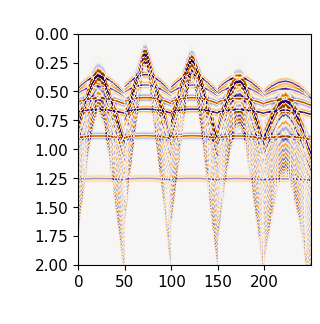

im

In [11]:
SeisPlotTX(d,wbox=3,hbox=3,oy=0,dy=dt)